In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('../Data/selected_data/merged_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217242 entries, 0 to 217241
Data columns (total 32 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Unnamed: 0           217242 non-null  int64  
 1   batter               217242 non-null  object 
 2   bowler               217242 non-null  object 
 3   non_striker          217242 non-null  object 
 4   runs_by_bat          217242 non-null  int64  
 5   extra_runs           217242 non-null  int64  
 6   total_runs_delivery  217242 non-null  int64  
 7   current_team_total   217242 non-null  int64  
 8   runs_remain          103118 non-null  float64
 9   batter_runs          217242 non-null  int64  
 10  balls_faced          217242 non-null  int64  
 11  wickets_fallen       217242 non-null  int64  
 12  extra_type           217242 non-null  object 
 13  delivery             217242 non-null  float64
 14  over                 217242 non-null  int64  
 15  wicket_type      

C:\Users\kaush\AppData\Local\Temp\ipykernel_21240\1736518648.py:6: DtypeWarning: Columns (30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../Data/selected_data/merged_data.csv')


In [3]:
# career strike rate
def get_career_sr(player_name: str) -> pd.DataFrame:
    # Get the data for BKG Mendis if batter is BKG Mendis or non-striker is BKG Mendis
	player_data = data.loc[
		((data['batter'] == player_name) | (data['non_striker'] == player_name)) & (data['innings'] <= 2)
	]

	player_data.head()

	
	# group data by match_id
	gp = player_data.groupby('match_id')
	cols = [ 'batter', 'non_striker', 'batter_runs', 'balls_faced']
	player_scores= gp.last().loc[:, cols]

	
	# when player is the non-striker when the last ball was bowled
	# The batter_runs and balls_faced are not his, but the on_strike batter's
	# So, we need to get the last ball he faced
	# he might not even have faced a ball

	# get the last ball he faced

	matches_non_striker = player_scores[player_scores['non_striker'] == player_name].index
	
	# Sometimes the player might not even have faced a single ball
	# Eg: Afghanistan_Sri Lanka_2022-11-01 MD Shanaka not out on the non strikers end

	player_scores.loc[matches_non_striker, ['batter_runs', 'balls_faced']] = [0, 0]
	
	
	# get the last batter == player_name row from gp data
	gp = player_data[(player_data['batter'] == player_name) & (player_data['match_id'].isin(matches_non_striker))].groupby(['match_id'])
	last_batter_scores = gp.last()[['batter_runs', 'balls_faced']]	
	
	# update the rows with non_striker with correct values
	player_scores.update(last_batter_scores)
	
	
	# adding new features
	# strike rate
	career_sr =round(player_scores['batter_runs'].sum() / player_scores['balls_faced'].sum() * 100, 2)
	return career_sr

get_career_sr('BKG Mendis')

129.79

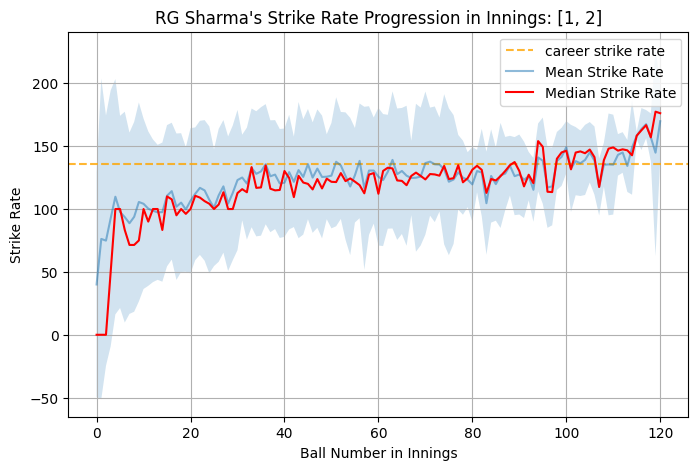

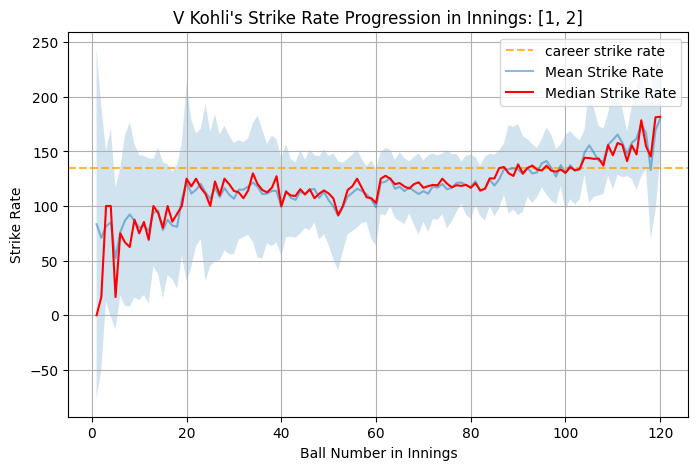

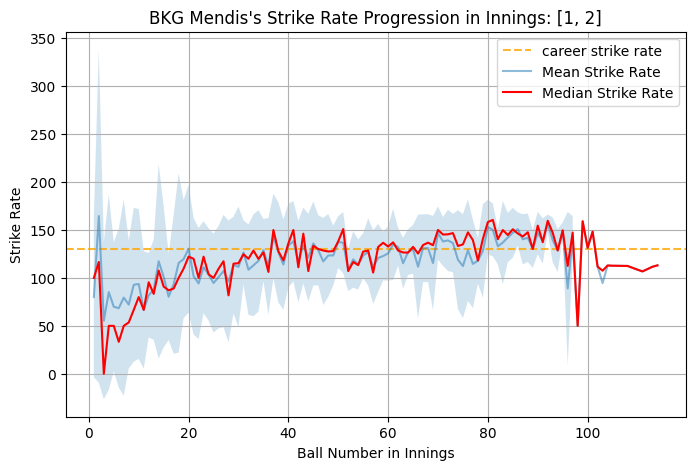

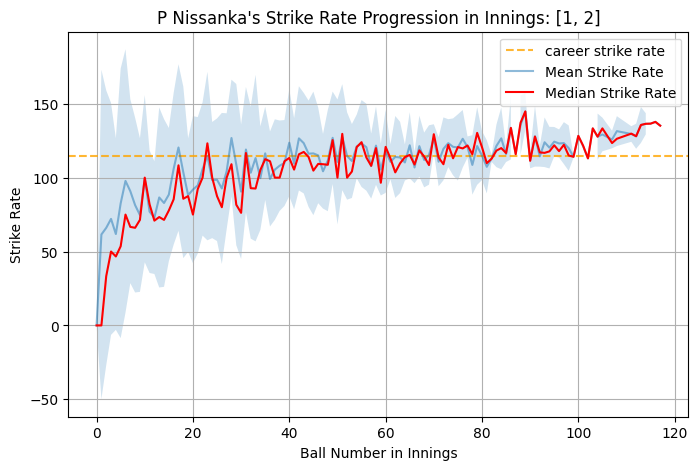

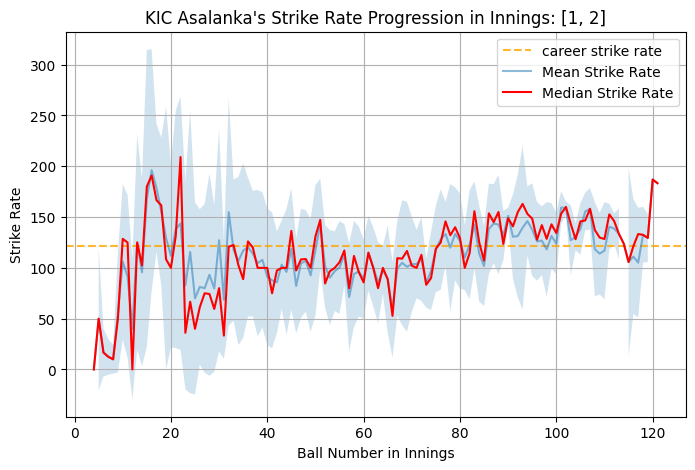

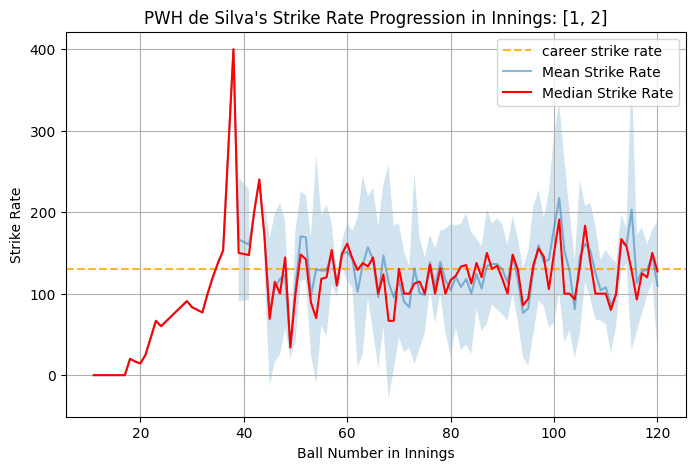

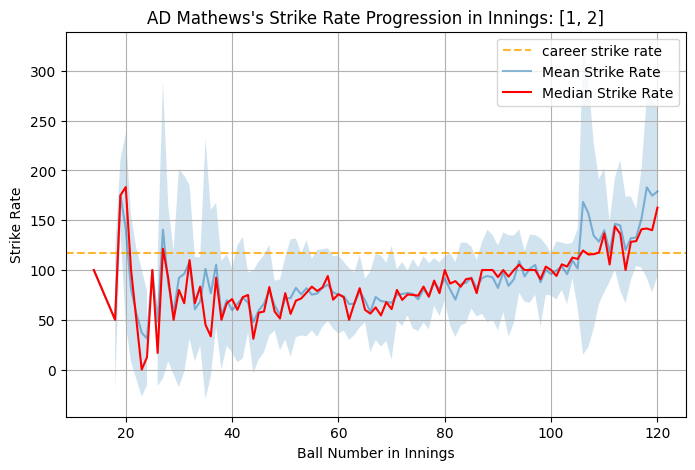

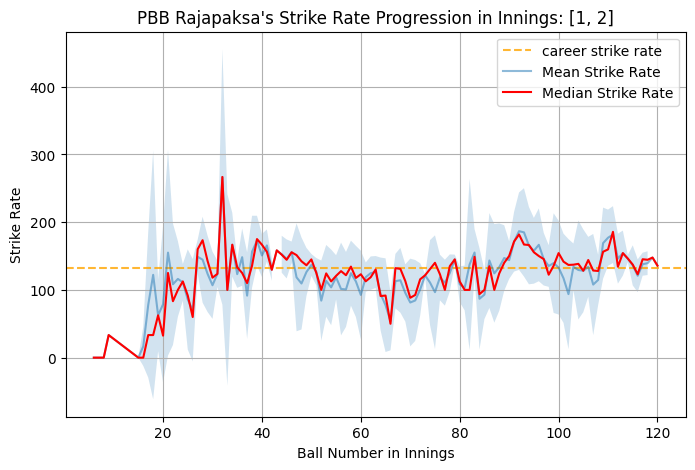

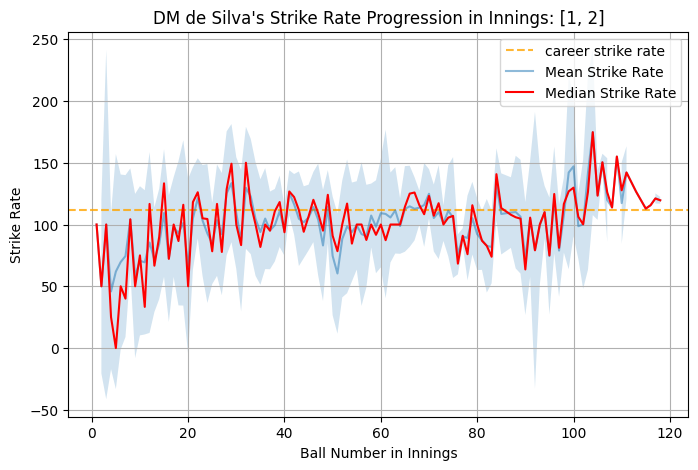

In [4]:

def strike_rate_progression_plot(player_name: str, innings: list[int] = [1,2]):
	player_data = data.loc[
			(data['batter'] == player_name) & (data['innings'].isin(innings))
		]
	cols = ['over', 'delivery','wickets_fallen', 'batter_runs', 'balls_faced', 'innings', 'match_id', 'won']
	player_data = player_data[cols]
	player_data['strike_rate'] = round(player_data['batter_runs'] / player_data['balls_faced'] * 100, 2)
	player_data['ball_number'] = (player_data['over'] * 6 + player_data['delivery']).astype(int)
	player_data.drop(['over', 'delivery'], inplace=True, axis=1)

	strike_rate_data = player_data.groupby(['ball_number'])['strike_rate']
	
	career_sr = get_career_sr(player_name)
	
	mean_sr = strike_rate_data.mean()
	median_sr = strike_rate_data.median()
	std_sr = strike_rate_data.std()
	plt.figure(figsize=(8,5))
	plt.axhline(y=career_sr, color='orange', alpha = 0.8, linestyle='--', label='career strike rate')
	plt.plot(mean_sr, label='Mean Strike Rate', alpha = 0.5 )
	plt.fill_between(mean_sr.index, mean_sr - std_sr, mean_sr + std_sr, alpha=0.2)
	plt.plot(median_sr, label='Median Strike Rate', c='red')
	plt.ylabel("Strike Rate")
	plt.xlabel("Ball Number in Innings")
	plt.grid()
	plt.legend()
	plt.title(f"{player_name}'s Strike Rate Progression in Innings: {innings}")
	plt.show()


players = ['RG Sharma', 'V Kohli', 'BKG Mendis', 'P Nissanka', 'KIC Asalanka', 'PWH de Silva', 'AD Mathews', 'PBB Rajapaksa' , 'DM de Silva']
for player in players:
	strike_rate_progression_plot(player, innings = [1, 2])

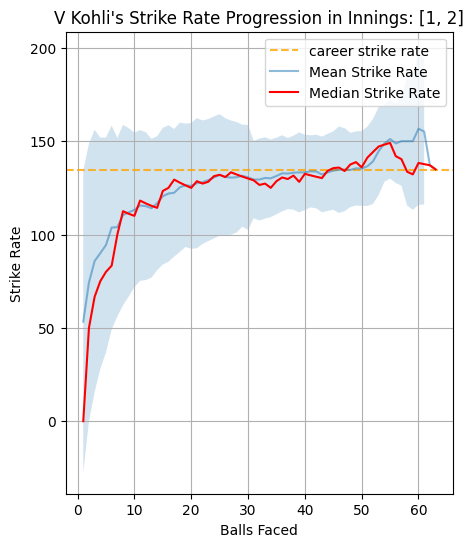

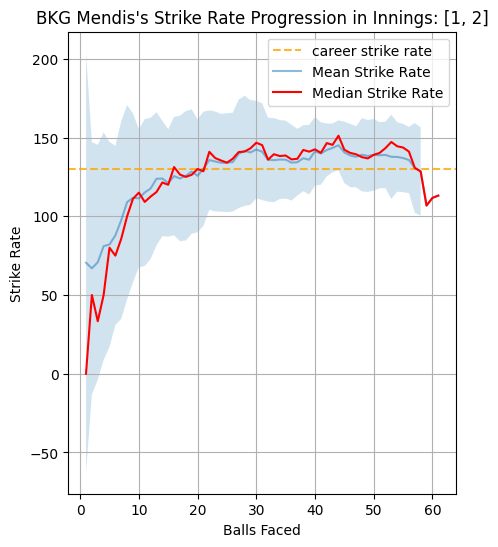

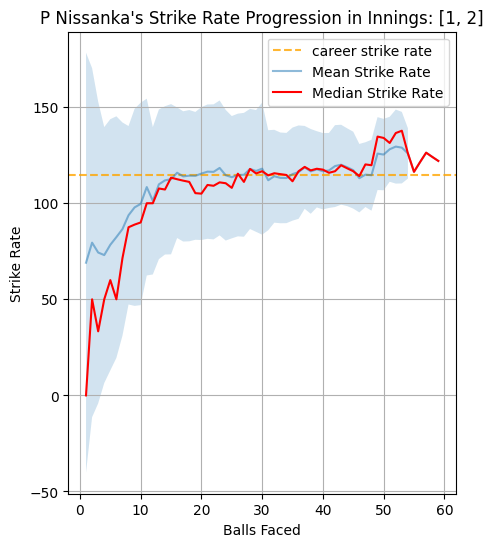

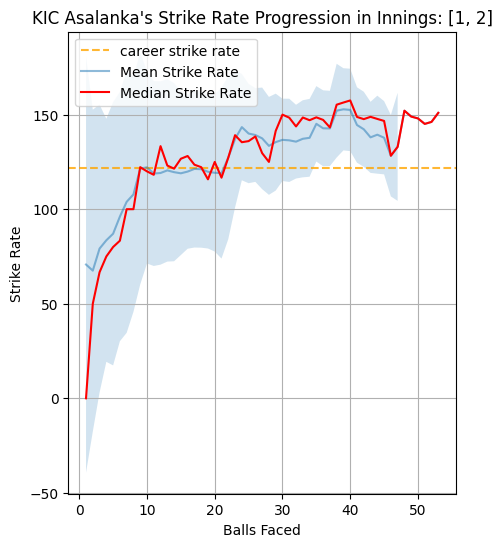

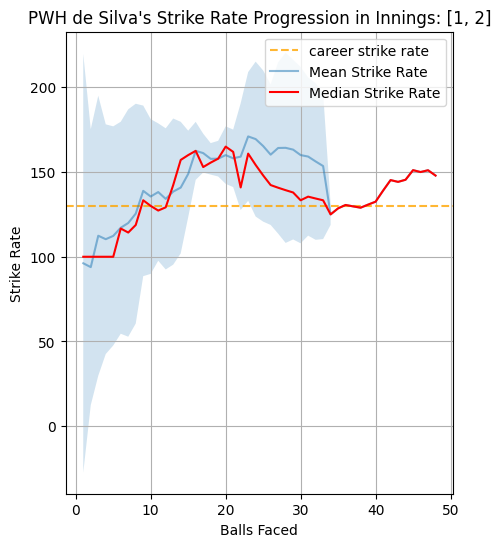

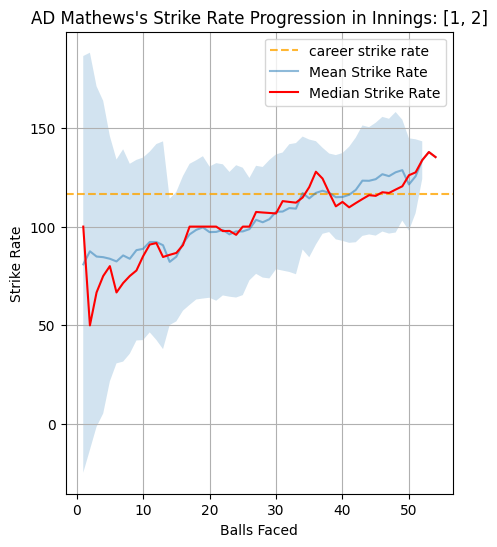

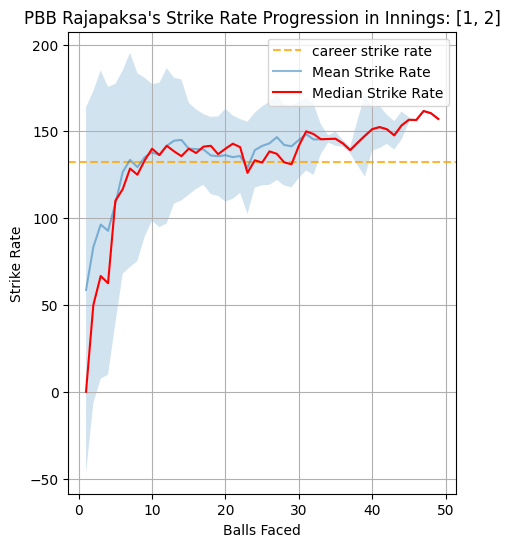

In [5]:

def strike_rate_progression_with_balls_faced_plot(player_name: str, innings: list[int] = [1,2]):
	player_data = data.loc[
			(data['batter'] == player_name) & (data['innings'].isin(innings))
		]
	cols = ['wickets_fallen', 'batter_runs', 'balls_faced', 'innings', 'match_id', 'won']
	player_data = player_data[cols]
	player_data['strike_rate'] = round(player_data['batter_runs'] / player_data['balls_faced'] * 100, 2)
	

	strike_rate_data = player_data.groupby(['balls_faced'])['strike_rate']

	career_sr = get_career_sr(player_name)
	mean_sr = strike_rate_data.mean()
	median_sr = strike_rate_data.median()
	std_sr = strike_rate_data.std()
	plt.figure(figsize=(5,6))
	plt.axhline(y=career_sr, color='orange', alpha = 0.8, linestyle='--', label='career strike rate')
	plt.plot(mean_sr, label='Mean Strike Rate', alpha = 0.5 )
	plt.fill_between(mean_sr.index, mean_sr - std_sr, mean_sr + std_sr, alpha=0.2)
	plt.plot(median_sr, label='Median Strike Rate', c='red')
	plt.xlabel("Balls Faced")
	plt.ylabel("Strike Rate")
	plt.grid()
	plt.legend()
	plt.title(f"{player_name}'s Strike Rate Progression in Innings: {innings}")
	plt.show()


players = ['V Kohli', 'BKG Mendis', 'P Nissanka', 'KIC Asalanka', 'PWH de Silva', 'AD Mathews', 'PBB Rajapaksa']
for player in players:
	strike_rate_progression_with_balls_faced_plot(player, innings = [1, 2])